<a href="https://colab.research.google.com/github/piziomo/Data-Science-Trainings/blob/main/IM939_Lab_3_1_Data_Processing_and_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Data Processing and Summarization

Here we will be exploring different functions in data processing and summarization.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Importing libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.spatial.distance import cdist # This is the function that computes the Mahalanobis distance
from scipy.stats import skew, kurtosis # The skew and kurtosis of a distribution
from statsmodels.robust.scale import mad # This computes the median absolute deviation of a distribution
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline # Display matplotlib plots inline with the text. +info: https://stackoverflow.com/a/43028034/1913457

## Outliers

In this section we will be applying several methods to identify outliers. We will be using a custom dataset called `accord_sedan.csv` that contains cars properties. The dataset is provided as a csv file.

### Assess data

As usual, we will want to start loading the data and assessing it:

In [ ]:
# Loading Data
df = pd.read_csv('data/raw/accord_sedan.csv')

# Inspecting the few first rows of the dataframe
df.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


And we can get some summary statistics, too:

In [ ]:
df.describe()

,price,mileage,year
count,417.000000,417.000000,417.0
mean,12084.242206,89725.779376,2006.0
std,2061.430034,25957.872271,0.0
min,6900.000000,19160.000000,2006.0
25%,10779.000000,71844.000000,2006.0
50%,11995.000000,89900.000000,2006.0
75%,13000.000000,106705.000000,2006.0
max,18995.000000,149269.000000,2006.0


::: callout-caution

### Do this yourself:

We only get the summaries for the numeric values here. How about the others, such as `trim`, `engine` or `transmission`? Can you think of a way to get an idea of statistics that will provide you an overview of the distribution of these values? Also, do you think the mean of the `year` values make sense? What could be a better statistics here?


In [ ]:
# Select columns by index and describe them
df.iloc[:, 5:7].describe()

,transmission
count,417
unique,2
top,Automatic
freq,382


In [ ]:
## One thing to try is the describe function with an "all" parameter:
df.describe(include='all')

,price,mileage,year,trim,engine,transmission
count,417.000000,417.000000,417.0,417,417,417
unique,NaN,NaN,NaN,3,2,2
top,NaN,NaN,NaN,ex,4 Cyl,Automatic
freq,NaN,NaN,NaN,288,238,382
mean,12084.242206,89725.779376,2006.0,NaN,NaN,NaN
std,2061.430034,25957.872271,0.0,NaN,NaN,NaN
min,6900.000000,19160.000000,2006.0,NaN,NaN,NaN
25%,10779.000000,71844.000000,2006.0,NaN,NaN,NaN
50%,11995.000000,89900.000000,2006.0,NaN,NaN,NaN
75%,13000.000000,106705.000000,2006.0,NaN,NaN,NaN


In [ ]:
df.describe(include=['object'])

,trim,engine,transmission
count,417,417,417
unique,3,2,2
top,ex,4 Cyl,Automatic
freq,288,238,382


In [ ]:
df.describe(include=['int64'])

,price,mileage,year
count,417.000000,417.000000,417.0
mean,12084.242206,89725.779376,2006.0
std,2061.430034,25957.872271,0.0
min,6900.000000,19160.000000,2006.0
25%,10779.000000,71844.000000,2006.0
50%,11995.000000,89900.000000,2006.0
75%,13000.000000,106705.000000,2006.0
max,18995.000000,149269.000000,2006.0


<Axes: xlabel='mileage', ylabel='Count'>

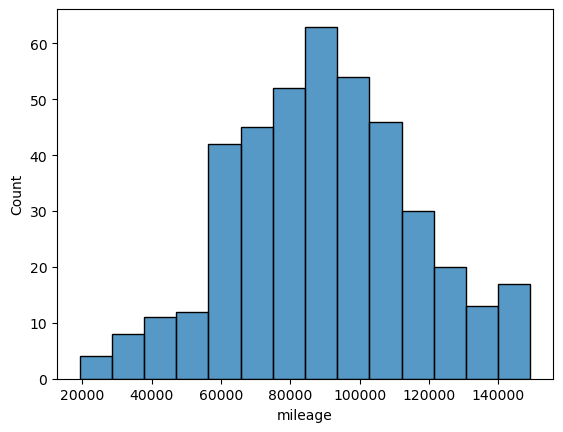

In [ ]:
#| eval: false # This is a comment for Quarto. Only makes sense for rendering the handbook.

# But this doesn't address our question. Think about visuals that can help you here? Maybe a histrogram would help?

sns.histplot(data=df, x="mileage")


:::

Once you have an idea of the descriptive statistics, you might want to focus on the outliers. It might be difficult to spot outliers just with the descriptive statistics. This is where we can use data visualisations to identify outliers visually and also make use of a few proxy metrics to help us assess data points.


### Identify outliers visually

In this case we will **explore variables individually (1D)** by creating a _boxplot_[^boxplot]. We will visualise the columns `price` and `mileage` using matplotlib's subplots, which combines multiple plots into a single figure:

[^boxplot]: Boxplots may be difficult to interpret if we are not used to them. It is used to visualise distributions, where the box represents the _Interquartile range (IQR)_, whereas the whiskers can be defined in multiple ways (e.g. the first and third quartiles, 1.5 IQR...) . ![A visualisation depicting how a Box Plot works. Source: [Wikipedia](https://en.wikipedia.org/wiki/Box_plot)](figs/440px-Boxplot_vs_PDF.svg.png) From [Wikipedia](https://en.wikipedia.org/wiki/Box_plot): "In descriptive statistics, a box plot or boxplot is a method for graphically demonstrating the locality, spread and skewness groups of numerical data through their quartiles."

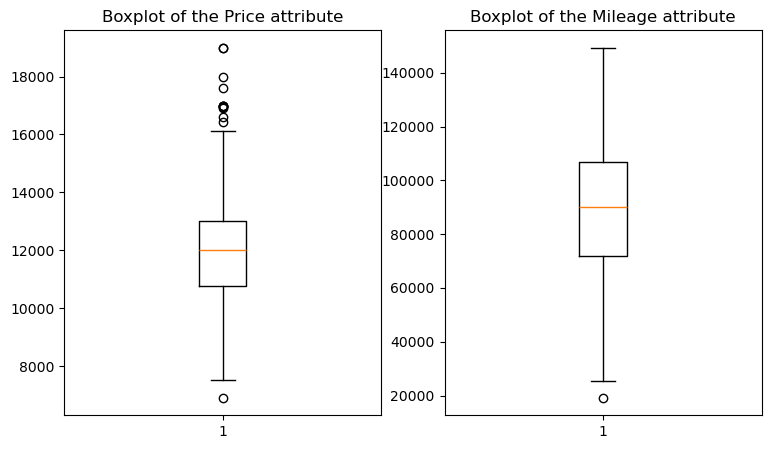

In [ ]:
# 1D Visualizations
plt.figure(figsize=(9, 5)) # Setting the figure's size: format width, height (in inches)
plt.subplot(1,2,1) # subplot(nrows, ncols, index, **kwargs)
plt.boxplot(df.price)
plt.title("Boxplot of the Price attribute")
plt.subplot(1,2,2)
plt.boxplot(df.mileage)
plt.title("Boxplot of the Mileage attribute");
# A semicolon in Python denotes separation, rather than termination.
# It allows you to write multiple statements on the same line.

But we may want to **identify the 2D outliers** using a scatterplot

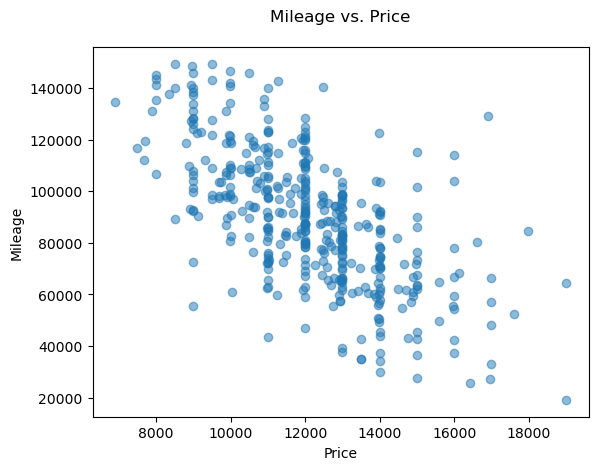

In [ ]:
# 2D Visualization
plt.scatter(df.price, df.mileage, alpha = .5)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.title('Mileage vs. Price\n');

::: callout-note
Visually, outliers appear to be outside the 'normal' range of the rest of the points. A few outliers are quite obvious to spot, but the choice of the threshold (the limit after which you decide to label a point as an outlier) visually remains a very subjective matter.
:::

### Computing outliers' threshold: standard deviation

Add two new columns to the dataframe called `isOutlierPrice` and `isOutlierMileage`. We will define our threshold as **2 times standard deviations away from the mean** for `price`  and `mileage`, respectively.

In [ ]:
# Computing the isOutlierPrice column
upper_threshold_price = df.price.mean() + 2*df.price.std()
lower_threshold_price = df.price.mean() - 2*df.price.std()
df['isOutlierPrice'] = ((df.price > upper_threshold_price) | (df.price < lower_threshold_price))

# Computing the isOutlierMileage column
upper_threshold_mileage = df.mileage.mean() + 2*df.mileage.std()
lower_threshold_mileage = df.mileage.mean() - 2*df.mileage.std()
df['isOutlierMileage'] = ((df.mileage > upper_threshold_mileage) | (df.mileage < lower_threshold_mileage))

# Inspect the new DataFrame with the added columns
df.head()

,price,mileage,year,trim,engine,transmission,isOutlierPrice,isOutlierMileage
0,14995,67697,2006,ex,4 Cyl,Manual,False,False
1,11988,73738,2006,ex,4 Cyl,Manual,False,False
2,11999,80313,2006,lx,4 Cyl,Automatic,False,False
3,12995,86096,2006,lx,4 Cyl,Automatic,False,False
4,11333,79607,2006,lx,4 Cyl,Automatic,False,False


::: callout-tip

### Alternative method

We may want to use this more succint approach:

In [ ]:
# Second way of doing the above using the np.where() function
df['isOutlierPrice'] = np.where(abs(df.price - df.price.mean()) < 2*df.price.std(), False, True)
df['isOutlierMileage'] = np.where(abs(df.mileage - df.mileage.mean()) < 2*df.mileage.std(), False, True)

# Inspect the new DataFrame with the added columns
df.head()

,price,mileage,year,trim,engine,transmission,isOutlierPrice,isOutlierMileage
0,14995,67697,2006,ex,4 Cyl,Manual,False,False
1,11988,73738,2006,ex,4 Cyl,Manual,False,False
2,11999,80313,2006,lx,4 Cyl,Automatic,False,False
3,12995,86096,2006,lx,4 Cyl,Automatic,False,False
4,11333,79607,2006,lx,4 Cyl,Automatic,False,False


As we'd expect, both methods produce the same output.

:::

Now that we have these two new columns, we could visualize these values with a different color in the plot. Observe whether they are the same as you would mark them:

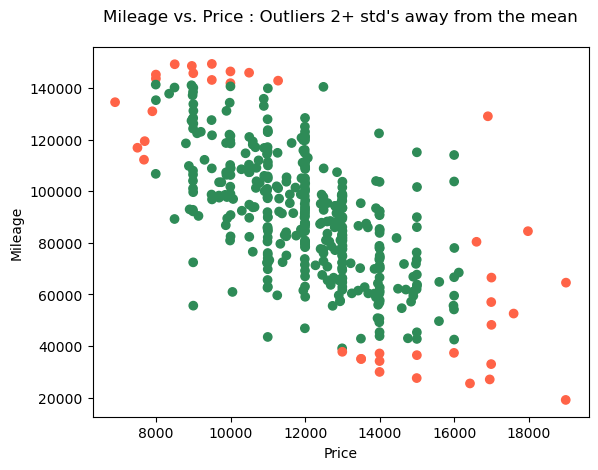

In [ ]:
# Visualizing outliers in a different color
col = ['tomato' if i+j else 'seagreen' for i,j in zip(df.isOutlierPrice, df.isOutlierMileage)]
plt.scatter(df.price, df.mileage, color = col)
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.title('Mileage vs. Price : Outliers 2+ std\'s away from the mean\n');

Visually filtering out outliers can be an effective tactic if we're just trying to conduct a quick and dirty experimentation. However, when we need to perform a solid and founded analysis, it's better to have a robust justification for our choices.  

In this case, we can use the deviation from the mean to define a threshold that separates 'normal' values from 'outliers'. Here, we opted for a two standard deviation threshold.

The mathematical intuition behind this, is that under the normality assumption (if we assume our variable is normally distributed, which it almost is, refer to the next plot), then the probability of it having a value two standard deviations OR MORE away from the mean, is around 5%, which is very unlikely to happen. This is why we label these data points as outliers with respect to the (assumed) probability distribution of the variable. But this remains a way to identify 1D outliers only (identifying outliers within each column separately)


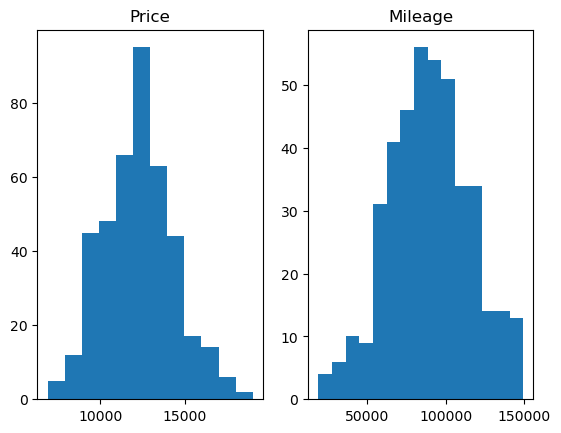

In [ ]:
# Histograms of Price and Mileage (checking the normality assumption)
plt.subplot(1,2,1)
plt.hist(df.price, bins = 12)
plt.title('Price')
plt.subplot(1,2,2)
plt.hist(df.mileage, bins = 15)
plt.title('Mileage');

### Computing outliers' threshold: Mahalanobis distance

1) Using the 2D Mahalanobis distance to find outliers

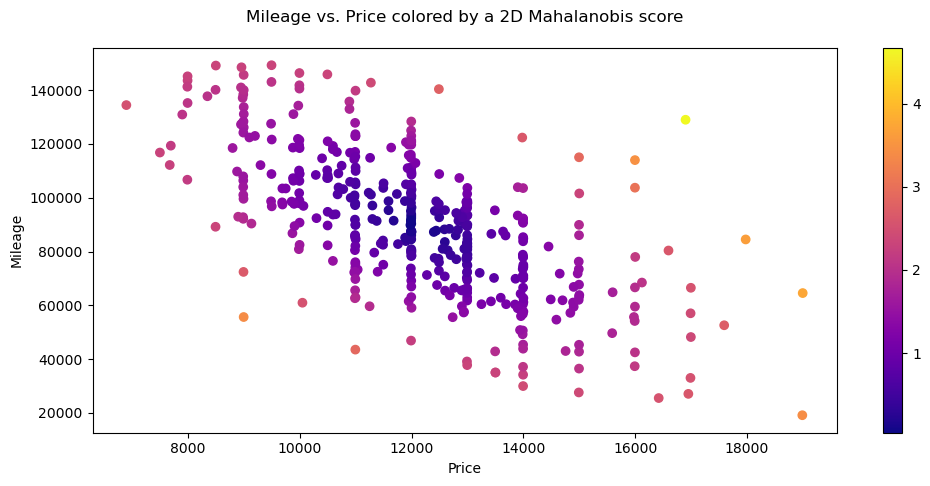

In [ ]:
#| column: page-inset-right

# Mean vector (computing the mean returns a Series, which we need to convert back to a DataFrame because cdist requires it)
mean_v = df.iloc[:, 0:2].mean().to_frame().T # DataFrame.T returns the Transpose of the DataFrame
#mean_v = np.asarray([df.price.mean(), df.mileage.mean()]).reshape(1,2) # This is a better way of writing the line before (for our use case : cdist function)

# Computing the Mahalanobis distance of each row to the mean vector
d = cdist(df.iloc[:, 0:2], mean_v, metric='mahalanobis')
#d = cdist(df[['price', 'mileage']].values, mean_v, metric='mahalanobis') # Another way of writing the line before

# Visualizing the scatter plot while coloring each point (i.e row) with a color from a chosen gradient colormap corresponding to the mahalanobis score
plt.figure(figsize=(12, 5))
plt.scatter(df.price, df.mileage, c = d.flatten(), cmap = 'plasma') # in order to know why we use flatten() on d, try printing d with and without flatten
plt.colorbar() # to show the colorbar
plt.xlabel('Price')
plt.ylabel('Mileage')
plt.title('Mileage vs. Price colored by a 2D Mahalanobis score\n');

## Q-Q Plots

### Data

In this case, we will be using data reported by countries to WHO and estimates of tuberculosis burden generated by WHO for the _Global Tuberculosis Report_, as part of WHO's [Global Tuberculosis Programme](https://www.who.int/teams/global-tuberculosis-programme/data). You can refer to [this section](https://www.who.int/teams/global-tuberculosis-programme/data#csv_files) at WHO's website to know more about the data and their variables.

For your convenience, we have stored a copy in a csv file, but you could try to replicate the code with more up-to-date data from the original website. As usual, it is a best practice to explore the data before proceeding any further:

In [ ]:
# Getting the Data
df_tuber = pd.read_csv('data/raw/TB_burden_countries_2014-09-29.csv')

df_tuber.head()

,country,iso2,iso3,iso_numeric,g_whoregion,year,e_pop_num,e_prev_100k,e_prev_100k_lo,e_prev_100k_hi,...,e_inc_tbhiv_100k,e_inc_tbhiv_100k_lo,e_inc_tbhiv_100k_hi,e_inc_tbhiv_num,e_inc_tbhiv_num_lo,e_inc_tbhiv_num_hi,source_tbhiv,c_cdr,c_cdr_lo,c_cdr_hi
0,Afghanistan,AF,AFG,4,EMR,1990,11731193,327.0,112.0,655.0,...,0.35,0.22,0.52,41.0,25.0,60.0,Model,20.0,13.0,32.0
1,Afghanistan,AF,AFG,4,EMR,1991,12612043,359.0,172.0,613.0,...,0.36,0.19,0.58,45.0,24.0,73.0,Model,97.0,77.0,120.0
2,Afghanistan,AF,AFG,4,EMR,1992,13811876,387.0,169.0,693.0,...,0.37,0.19,0.62,51.0,26.0,86.0,Model,NaN,NaN,NaN
3,Afghanistan,AF,AFG,4,EMR,1993,15175325,412.0,186.0,724.0,...,0.38,0.20,0.63,58.0,30.0,95.0,Model,NaN,NaN,NaN
4,Afghanistan,AF,AFG,4,EMR,1994,16485018,431.0,199.0,751.0,...,0.40,0.21,0.64,65.0,35.0,100.0,Model,NaN,NaN,NaN


In [ ]:
df_tuber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4903 entries, 0 to 4902
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   4903 non-null   object 
 1   iso2                      4880 non-null   object 
 2   iso3                      4903 non-null   object 
 3   iso_numeric               4903 non-null   int64  
 4   g_whoregion               4903 non-null   object 
 5   year                      4903 non-null   int64  
 6   e_pop_num                 4903 non-null   int64  
 7   e_prev_100k               4892 non-null   float64
 8   e_prev_100k_lo            4892 non-null   float64
 9   e_prev_100k_hi            4892 non-null   float64
 10  e_prev_num                4892 non-null   float64
 11  e_prev_num_lo             4892 non-null   float64
 12  e_prev_num_hi             4892 non-null   float64
 13  e_mort_exc_tbhiv_100k     4902 non-null   float64
 14  e_mort_e

As you can see we have a pretty large dataset numerical and categorical variables, some of which have many missing values. In this case we will be filling missing values with the mean[^missing-data]

[^missing-data]: Refer to @sec-inputting-missing-data for a detailed explanation and alternative methods to inputting missing values.

In [ ]:
# Filling missing numeric values ONLY (categorical values will be untouched)
df_tuber = df_tuber.fillna(value=df_tuber.mean(numeric_only = True))

# Count missing values
df_tuber.isna().sum()

country                      0
iso2                        23
iso3                         0
iso_numeric                  0
g_whoregion                  0
year                         0
e_pop_num                    0
e_prev_100k                  0
e_prev_100k_lo               0
e_prev_100k_hi               0
e_prev_num                   0
e_prev_num_lo                0
e_prev_num_hi                0
e_mort_exc_tbhiv_100k        0
e_mort_exc_tbhiv_100k_lo     0
e_mort_exc_tbhiv_100k_hi     0
e_mort_exc_tbhiv_num         0
e_mort_exc_tbhiv_num_lo      0
e_mort_exc_tbhiv_num_hi      0
source_mort                  1
e_inc_100k                   0
e_inc_100k_lo                0
e_inc_100k_hi                0
e_inc_num                    0
e_inc_num_lo                 0
e_inc_num_hi                 0
e_tbhiv_prct                 0
e_tbhiv_prct_lo              0
e_tbhiv_prct_hi              0
e_inc_tbhiv_100k             0
e_inc_tbhiv_100k_lo          0
e_inc_tbhiv_100k_hi          0
e_inc_tb

1) Pick one of the columns from the Tuberculosis data and copy it into a numpy array as before

In [ ]:
# Picking a column (I created a variable for this so I (and you (: ) can modify the column easily here and the change will be carried out everywhere I use the variable colname)
colname = 'e_pop_num'

# Creating a numpy array from our column
col = np.array(df_tuber[colname])

# Printing the type of our newly created column
print(type(col))

<class 'numpy.ndarray'>


2) Compare this selected column to a Normal distribution. Then Sample from a Normal distribution and show a second Q-Q plot

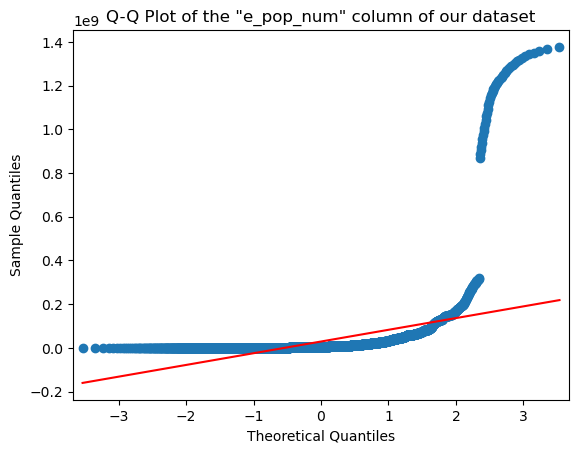

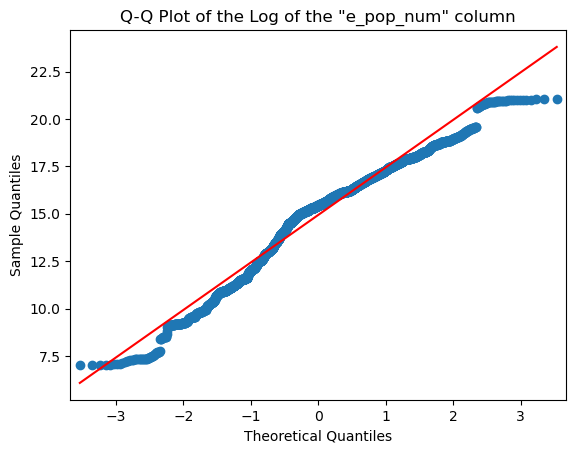

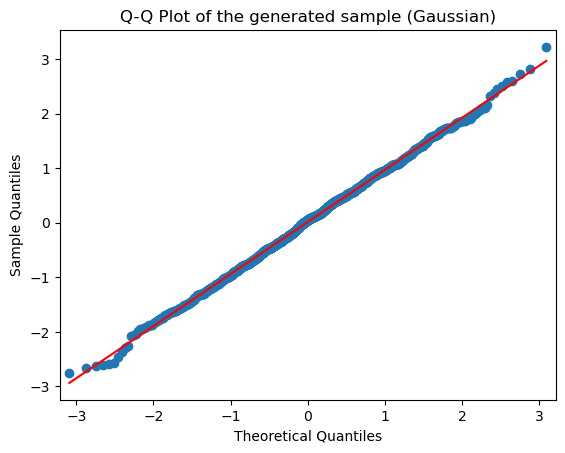

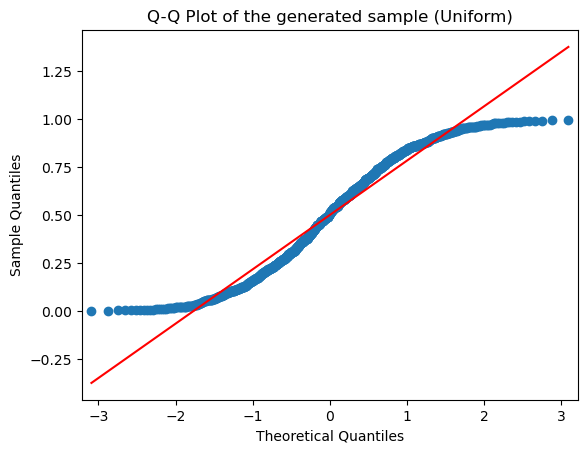

In [ ]:
# Plotting the Q-Q Plot for our column
sm.qqplot(col, line='r')
plt.title('Q-Q Plot of the "{}" column of our dataset'.format(colname));

# Plotting the Q-Q Plot for the log of our column
sm.qqplot(np.log(col), line='r')
plt.title('Q-Q Plot of the Log of the "{}" column'.format(colname));

# Sampling from a Gaussian and a uniform distribution
sample_norm = np.random.randn(1000)
sample_unif = np.random.rand(1000)

# Plotting the second Q-Q Plot for our sample (that was generated using a normal distribution)
sm.qqplot(sample_norm, line='r')
plt.title('Q-Q Plot of the generated sample (Gaussian)')
sm.qqplot(sample_unif, line='r')
plt.title('Q-Q Plot of the generated sample (Uniform)');

<p>
    Go ahead and change the colname variable (question 1) into a different column name (that you can pick from the list you have just before question 1 (but do pick a numeric column). And re-execute the code from question 1 and question 2 and you'll see your new Q-Q plot of the column you just picked.
</p>

1) Have a look at the slides from Week 03 for different shapes

<p>
    Ok ? Now try to guess the shape of the distribution of our selected column (shape of its histogram) from its Q-Q Plot above.
</p>

1) Visualise the column on a histogram and reflect on whether the shape you inferred from Q-Q plots and the shape of the histogram correlate

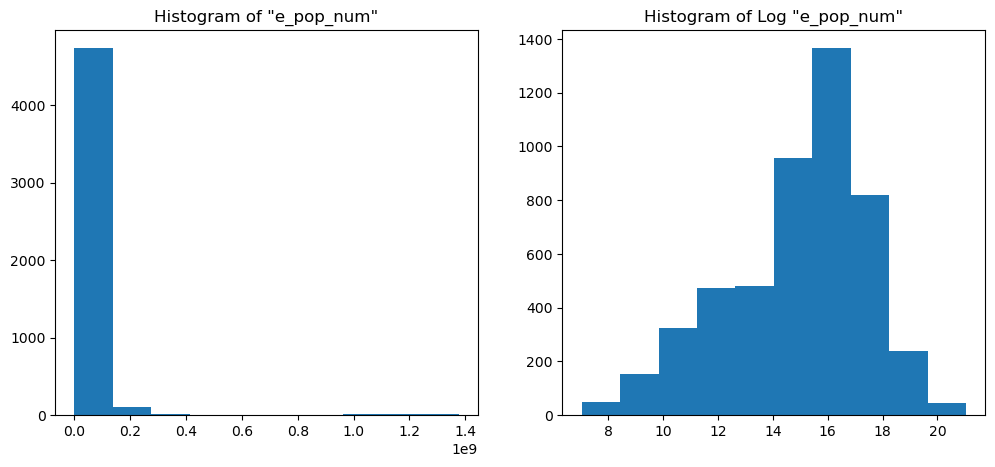

In [ ]:
#| column: page-inset-right

# Histogramming the column we picked (not sure the verb exists though)
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.title('Histogram of "{}"'.format(colname))
plt.hist(col)
plt.subplot(1,2,2)
plt.title('Histogram of Log "{}"'.format(colname))
plt.hist(np.log(col));

<p>
    Of course it does ! From the shape of the Q-Q Plot above (convex, slope upwards) and the Slide of Q-Q Plots from Week 3, we could conclude before looking at the histogram that our distribution was right tailed (or positively skewed if you're into complex vocabulary lol). And it is !
</p>

## Distributions, Sampling

1) Inspecting the effect of sample size on descriptive statistics

In [ ]:
# Defining a few variables so we can change their values easily without having to change the rest of the code
n = [5, 20, 100, 2000]
stds = [0.5, 1, 3]

# Initializing empty 2D arrays where we're going to store the results of our simulation
mean = np.empty([len(n), len(stds)])
std = np.empty([len(n), len(stds)])
skewness = np.empty([len(n), len(stds)])
kurtos = np.empty([len(n), len(stds)])

# Conducting the experiments and storing the results in the respective 2D arrays
for i, sample_size in enumerate(n):
    for j, theoritical_std in enumerate(stds):
        sample = np.random.normal(loc=0, scale=theoritical_std, size=sample_size)
        mean[i,j] = sample.mean()
        std[i,j] = sample.std()
        skewness[i,j] = skew(sample)
        kurtos[i,j] = kurtosis(sample)

# Turning the mean 2D array into a pandas dataframe
mean = pd.DataFrame(mean, columns = stds, index = n)
mean = mean.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

# Turning the std 2D array into a pandas dataframe
std = pd.DataFrame(std, columns = stds, index = n)
std = std.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

# Turning the skewness 2D array into a pandas dataframe
skewness = pd.DataFrame(skewness, columns = stds, index = n)
skewness = skewness.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

# Turning the kurtosis 2D array into a pandas dataframe
kurtos = pd.DataFrame(kurtos, columns = stds, index = n)
kurtos = kurtos.rename_axis('Sample Size').rename_axis("Standard Deviation", axis="columns")

print("GAUSSIAN DISTRIBUTION\n")
print('Results for the Mean :')
mean # This is a dataframe containing the means of the samples generated with different values of std and sample size
print('Results for the Standard Deviation :')
std # This is a dataframe containing the standard deviations of the samples generated with different values of std and sample size
print('Results for the Skewness :')
skewness # This is a dataframe containing the skews of the samples generated with different values of std and sample size
print('Results for the Kurtosis :')
kurtos # This is a dataframe containing the kurtosis of the samples generated with different values of std and sample size


GAUSSIAN DISTRIBUTION

Results for the Mean :
Results for the Standard Deviation :
Results for the Skewness :
Results for the Kurtosis :


Standard Deviation,0.5,1.0,3.0
Sample Size,,,
5,-1.496347,-0.258649,-1.196405
20,-0.803811,-0.092778,-0.542372
100,-0.070233,-0.184011,1.644577
2000,-0.022516,-0.246838,-0.019455


In [ ]:
# are the outputs overwritten? Try this instead
# concatenate the dataframes
combined_df = pd.concat([mean, std, skewness, kurtos], keys=['Mean', 'Standard Deviation', 'Skewness', 'Kurtosis'])

# Print combined DataFrame
print(combined_df)

Standard Deviation                   0.5       1.0       3.0
                   Sample Size                              
Mean               5            0.445181 -1.037363 -1.860563
                   20          -0.272638  0.240505  0.320150
                   100         -0.026967 -0.027953 -0.278606
                   2000         0.001310 -0.002632 -0.009478
Standard Deviation 5            0.307941  0.705153  4.039752
                   20           0.457466  1.028058  2.839099
                   100          0.476129  0.987116  2.800394
                   2000         0.502364  0.986720  3.006927
Skewness           5           -0.199030 -1.065861  0.380621
                   20           0.104005 -0.311527 -0.719133
                   100          0.114181 -0.089082  0.693686
                   2000         0.072425 -0.054646  0.071194
Kurtosis           5           -1.496347 -0.258649 -1.196405
                   20          -0.803811 -0.092778 -0.542372
                   100  

<p>
    Basically, the more data you have (the bigger your sample), the more accurate your empirical estimates are going to be. Observe for example the values of mean (1st DataFrame) and variance (2nd DataFrame) for the 2000 sample size (last row). In the first one, the values are all close to 0, because we generated our sample from a Gaussian with mean 0, and the values in the second one are all close to the values in the column names (which refer to the variance of the distribution of the sample). This means that for with a sample size of 2000, our estimates are really close to the "True" values (with which we generated the sample). Also, the Skew of a Gaussian distribution should be 0, and it is confirmed in the 3rd DataFrame where the values are close to 0 in the last row (i.e big sample size).
</p>

<b>2) Same as before but with a Poisson distribution (which has just one parameter lambda instead of 2 like the gaussian)</b>

In [ ]:
# Defining a few variables se we can change their values easily without having to change the rest of the code
n = [5, 20, 100, 2000]
lambd = [0.5, 1, 3] # In a gaussian we had two parameters, a var specified here and a mean we chose to be 0
#everywhere. Here we have one parameter called lambda.

# Initializing empty 2D arrays where we're going to store the results of our simulation
mean = np.empty([len(n), len(lambd)])
std = np.empty([len(n), len(lambd)])
skewness = np.empty([len(n), len(lambd)])
kurtos = np.empty([len(n), len(lambd)])

# Conducting the experiments and storing the results in the respective 2D arrays
for i, sample_size in enumerate(n):
    for j, theoritical_lambd in enumerate(lambd):
        #**********************************************************************
        sample = np.random.poisson(lam = theoritical_lambd, size = sample_size) # THIS IS WHAT WE CHANGED FROM ABOVE
        #**********************************************************************
        mean[i,j] = sample.mean()
        std[i,j] = sample.std()
        skewness[i,j] = skew(sample)
        kurtos[i,j] = kurtosis(sample)

# Turning the mean 2D array into a pandas dataframe
mean = pd.DataFrame(mean, columns = lambd, index = n)
mean = mean.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

# Turning the std 2D array into a pandas dataframe
std = pd.DataFrame(std, columns = lambd, index = n)
std = std.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

# Turning the skewness 2D array into a pandas dataframe
skewness = pd.DataFrame(skewness, columns = lambd, index = n)
skewness = skewness.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

# Turning the kurtosis 2D array into a pandas dataframe
kurtos = pd.DataFrame(kurtos, columns = lambd, index = n)
kurtos = kurtos.rename_axis('Sample Size').rename_axis("Lambda", axis="columns")

print("POISSON DISTRIBUTION\n")
print('Results for the Mean :')
mean # This is a dataframe containing the means of the samples generated with different values of std and sample size
print('Results for the Standard Deviation :')
std # This is a dataframe containing the standard deviations of the samples generated with different values of std
#and sample size
print('Results for the Skewness :')
skewness # This is a dataframe containing the skews of the samples generated with different values of std and sample
#size
print('Results for the Kurtosis :')
kurtos # This is a dataframe containing the kurtosis of the samples generated with different values of std and sample
#size

POISSON DISTRIBUTION

Results for the Mean :
Results for the Standard Deviation :
Results for the Skewness :
Results for the Kurtosis :


Lambda,0.5,1.0,3.0
Sample Size,,,
5,-0.500000,-1.833333,-0.500000
20,-0.869837,0.611387,-0.631374
100,1.929642,0.564919,-0.148220
2000,1.976347,0.750929,0.425968


<p>
    Just remember, the lambda parameter that defines the Poisson distribution is also the mean of the distribution. This is confirmed in the first DataFrame where the values (means of samples) are close to the column labels (theoretical lambda which is also equal to theoretical mean), especially in the last row.
</p>

## Robust Statistics

1) Choose a number of columns with different shapes, for instance, "e_prev_100k_hi" is left skewed or some columns where the variation is high or you notice potential outliers. You can make use of a series of boxplots to exploratively analyse the data for outliers

In [ ]:
# Listing the columns
df_tuber.columns

Index(['country', 'iso2', 'iso3', 'iso_numeric', 'g_whoregion', 'year',
       'e_pop_num', 'e_prev_100k', 'e_prev_100k_lo', 'e_prev_100k_hi',
       'e_prev_num', 'e_prev_num_lo', 'e_prev_num_hi', 'e_mort_exc_tbhiv_100k',
       'e_mort_exc_tbhiv_100k_lo', 'e_mort_exc_tbhiv_100k_hi',
       'e_mort_exc_tbhiv_num', 'e_mort_exc_tbhiv_num_lo',
       'e_mort_exc_tbhiv_num_hi', 'source_mort', 'e_inc_100k', 'e_inc_100k_lo',
       'e_inc_100k_hi', 'e_inc_num', 'e_inc_num_lo', 'e_inc_num_hi',
       'e_tbhiv_prct', 'e_tbhiv_prct_lo', 'e_tbhiv_prct_hi',
       'e_inc_tbhiv_100k', 'e_inc_tbhiv_100k_lo', 'e_inc_tbhiv_100k_hi',
       'e_inc_tbhiv_num', 'e_inc_tbhiv_num_lo', 'e_inc_tbhiv_num_hi',
       'source_tbhiv', 'c_cdr', 'c_cdr_lo', 'c_cdr_hi'],
      dtype='object')

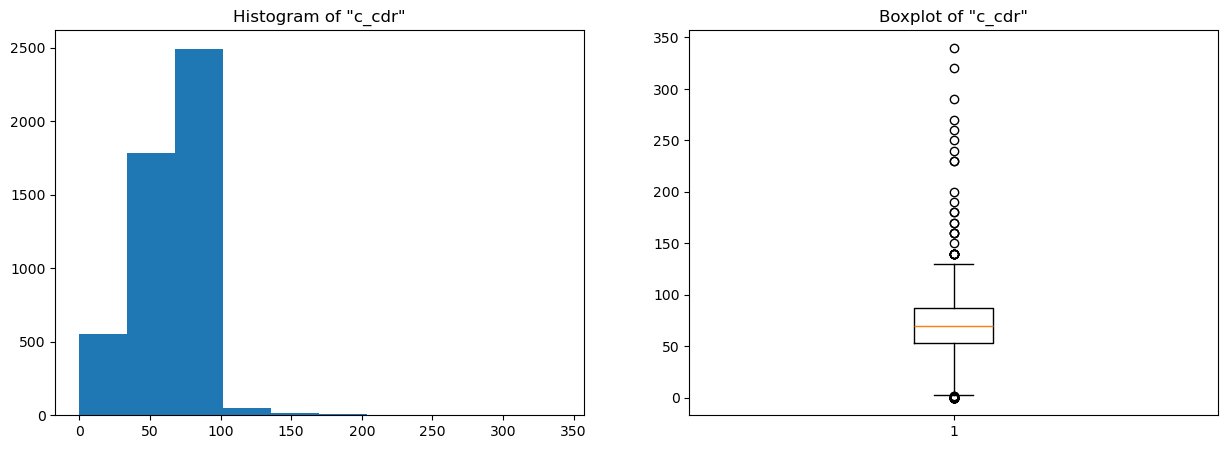

In [ ]:
#| column: screen-inset

# Alright I already know a few columns with outliers but let's try to find them together exploratively using BoxPlots
colname = 'c_cdr' # change the column name by choosing different ones from above (numeric ones)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(df_tuber[colname])
plt.title('Histogram of "{}"'.format(colname))
plt.subplot(1,2,2)
plt.boxplot(df_tuber[colname]);
plt.title('Boxplot of "{}"'.format(colname));

In [ ]:
# Chosen columns : I picked 3, feel free to change them and experiment
chosen_colnames = ['e_pop_num', 'e_prev_100k', 'c_cdr']

<b>2) For the chosen columns, estimate both the conventional and the robust descriptive statistics and compare. Observe how these pairs deviate from each other based on the characteristics of the underlying data</b>

In [ ]:
# Central Tendency : Mean vs Median (Median is the robust version of the mean, because it takes into account
#the ordering of the points and not the actual values like the mean does)
df_tuber[chosen_colnames].describe().loc[['mean', '50%'], :] # The 50% is the median (50% quantile)

,e_pop_num,e_prev_100k,c_cdr
mean,2.899179e+07,207.694422,67.570706
50%,5.140332e+06,93.000000,70.000000


Look at how the values are different between the mean and the median ... LOOOOOOOK ! This is why when you have a skewed (unsymmetrical) distribution it's usually more interesting to use the median as a measure of the central tendency of the data. One important thing to note here, for the two first attributes, the mean is higher than the median, but for the last it's the opposite. This can tell you a thing or two about the shape of your distribution : if the mean is higher than the median, this means that the distribution is skewed to the right (right tail) which pulls the mean higher. And vice-versa.


Moral of the story is ... outliers can be a pain!

In [ ]:
# Spread : Standard Deviation vs Inter-Quartile Range vs Median Absolute Deviation (MAD)
stds = df_tuber[chosen_colnames].std()
iqrs = df_tuber[chosen_colnames].quantile(0.75) - df_tuber[chosen_colnames].quantile(0.25)
medianAD = mad(df_tuber[chosen_colnames])

output = pd.DataFrame(stds, columns = ['std']).T
output = pd.concat([output, pd.DataFrame(iqrs, columns = ['IQR']).T], ignore_index=False)
output = pd.concat([output, pd.DataFrame(medianAD, columns = ['MAD'], index = chosen_colnames).T], ignore_index=False, names = ['std', 'iqr', 'mad'])
output

,e_pop_num,e_prev_100k,c_cdr
std,1.177827e+08,269.418159,25.234773
IQR,1.677193e+07,280.500000,34.000000
MAD,7.454908e+06,120.090780,25.204238


The values here are different as well, maybe more so for the "e_pop_num" attribute than the others, but that is just because of the scaling : "e_pop_num" takes big values overall compared to the other columns, which you can check with the mean values right above.

For the first attribute, the standard deviation is higher, and both the IQR and MAD are close to each other. For the second attribute, the inter-quartile range is slightly higher than the standard deviation, but the MAD is far below (less than half) the other two values, and the reason for that is a little bit involved : Basically, the standard deviation measures the spread by computing the squared deviation from the mean while the median absolute deviation evaluates the spread by computing the absolute deviation. This means that when the outliers have much bigger values than the "normal" points, the squared difference explodes (figuratively of course ;p) compared to the absolute difference. And this is actually the case for our second distribution (e_prev_100k) where most values are between 50 and 300 while many outliers lay above the 750 mark and go all the way up to 1800 (look at the boxplots below). For the third attribute the values are somewhat close, especially the std and the MAD, that's because if you inspect the boxplot, this column doesn't have many outliers to begin with.

Nonetheless, the differences are real, and if we don't want to have to handle outliers, then we should be using robust statistics like the median to describe the central tendency and inter-quartile range or median absolute deviation to measure the spread of our data.

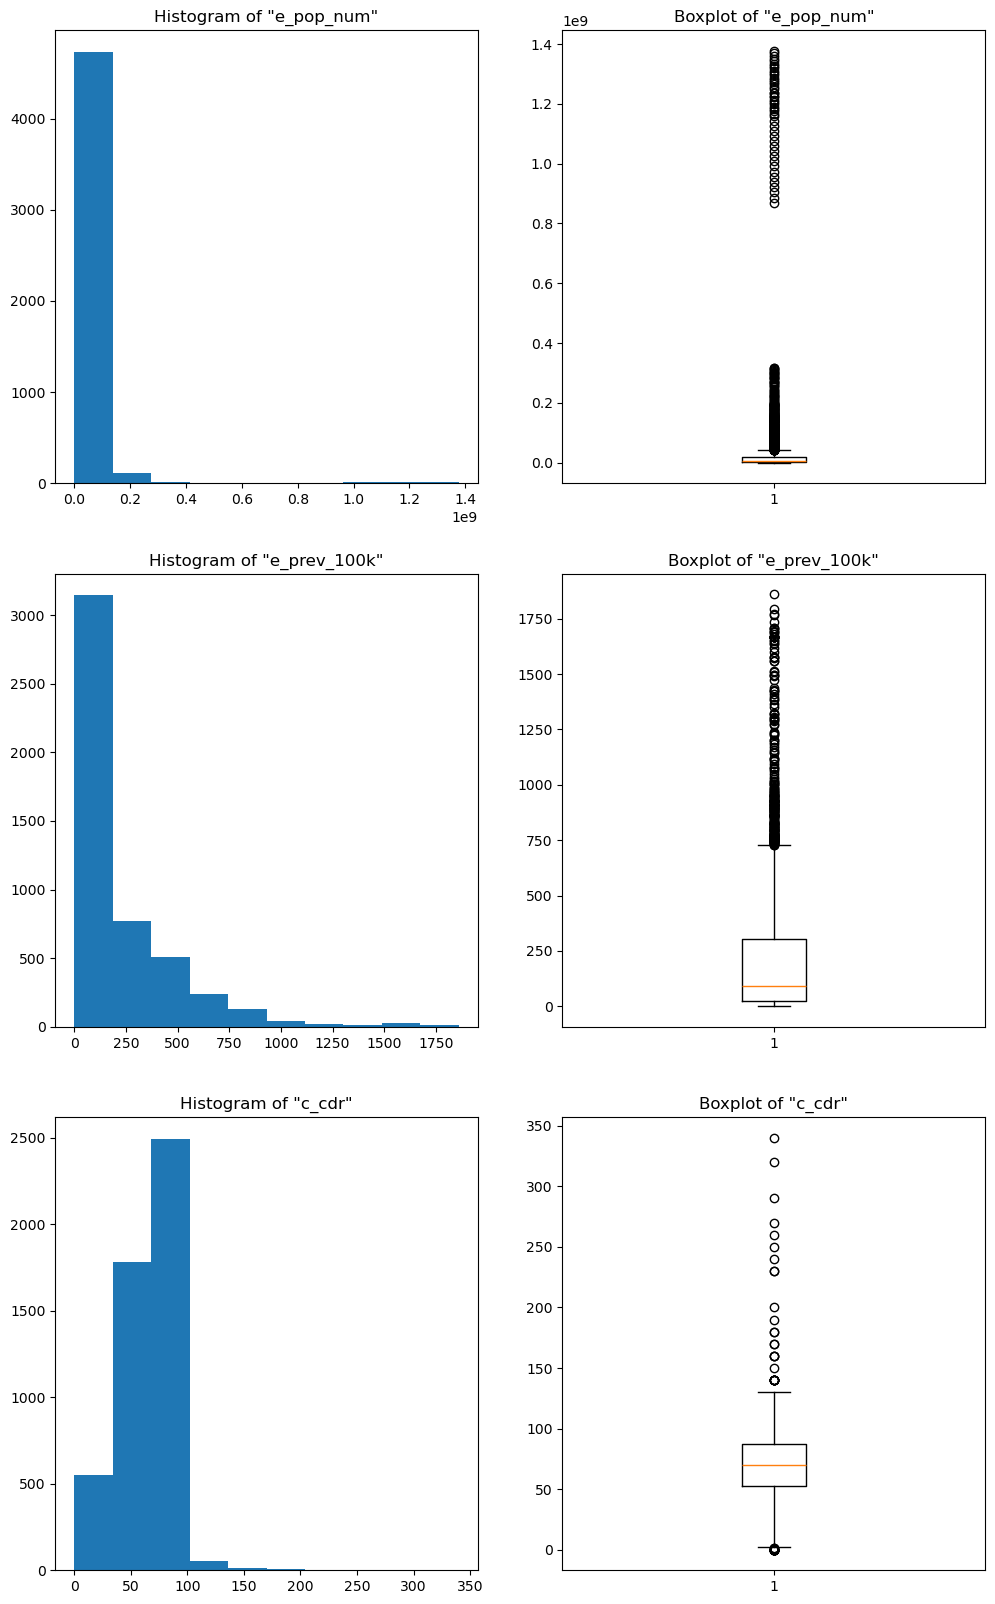

In [ ]:
#| column: page-inset-right

# Boxplots of the different columns
plt.figure(figsize=(12,20))

plt.subplot(3,2,1)
plt.hist(df_tuber[chosen_colnames[0]])
plt.title('Histogram of "{}"'.format(chosen_colnames[0]))
plt.subplot(3,2,2)
plt.boxplot(df_tuber[chosen_colnames[0]])
plt.title('Boxplot of "{}"'.format(chosen_colnames[0]))

plt.subplot(3,2,3)
plt.hist(df_tuber[chosen_colnames[1]])
plt.title('Histogram of "{}"'.format(chosen_colnames[1]))
plt.subplot(3,2,4)
plt.boxplot(df_tuber[chosen_colnames[1]])
plt.title('Boxplot of "{}"'.format(chosen_colnames[1]))

plt.subplot(3,2,5)
plt.hist(df_tuber[chosen_colnames[2]])
plt.title('Histogram of "{}"'.format(chosen_colnames[2]))
plt.subplot(3,2,6)
plt.boxplot(df_tuber[chosen_colnames[2]])
plt.title('Boxplot of "{}"'.format(chosen_colnames[2]));